<a href="https://colab.research.google.com/github/RahulJuluru2/unit4assignments/blob/main/U4W23_55_Spam_Detection_Using_BERT_C_RJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objectives

At the end of the experiment, you will be able to:

* understand  BERT (Bidirectional Encoder Representations from Transformers)  Algorithm implementation
* understand how to preprocess text into an appropriate format


In [1]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="850" height="480" controls>
  <source src="https://cdn.exec.talentsprint.com/non-processed/SPAM_Detection.mp4" type="video/mp4">
</video>
""")

### Dataset Description

The spam and ham dataset have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham or spam.



#### Setup Steps

In [2]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "2216842" #@param {type:"string"}


In [3]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "9959488784" #@param {type:"string"}


In [4]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")

ipython = get_ipython()
  
notebook= "U4W23_55_Spam_Detection_Using_BERT_C" #name of the notebook


def setup():
    ipython.magic("sx wget -qq https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/spam_data.csv")
    ipython.magic("sx pip install tensorflow_text")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None
    
    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getWalkthrough() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook, "feedback_walkthrough":Walkthrough ,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}

      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:        
        print(r["err"])
        return None   
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://aiml.iiith.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if not Additional: 
      raise NameError
    else:
      return Additional  
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None
  
  
def getWalkthrough():
  try:
    if not Walkthrough:
      raise NameError
    else:
      return Walkthrough
  except NameError:
    print ("Please answer Walkthrough Question")
    return None
  
def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None
  

def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError 
    else: 
      return Answer
  except NameError:
    print ("Please answer Question")
    return None
  

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup() 
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


**Import the Libraries**

In [5]:
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix , classification_report

**Load the Data**

In [6]:
data = pd.read_csv('/content/spam_data.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Pre-Processing

In [7]:
# Check count of the unique rows in the DataFrame
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

As the data is imbalanced and there are more good emails(ham) than spam emails. This may lead to OVERFITTING as a model may learn all the features of the ham emails over spam emails. So, downsample the data before preparing the model.

**Downsampling Data**

Downsampling is a technique where the majority class is downsampled to match the minority class. So, perform downsampling by just picking any random 747 samples from the ham class. 

In [8]:
# Collect spam and ham datasets

df_spam = data[data['Category']=='spam']
df_ham = data[data['Category']=='ham']

print("Ham Dataset Shape:", df_ham.shape)
print("Spam Dataset Shape:", df_spam.shape)

Ham Dataset Shape: (4825, 2)
Spam Dataset Shape: (747, 2)


In [9]:
# Downsample ham dataset by taking only random 747 example
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [10]:
# Concatinate both datasets and verify the unique rows count of the class labels
df_balanced = pd.concat([df_spam , df_ham_downsampled])
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

**LabelEncoder**

LabelEncoder converts the categorical features into numeric values. LabelEncoder encode labels with a value between 0 and n_classes-1, where n is the number of distinct labels

In [11]:
# Convert the labels into a numeric form using LabelEncoder
label_encoder = preprocessing.LabelEncoder()
df_balanced['Category'] = label_encoder.fit_transform(df_balanced['Category'])
df_balanced['Category'].unique()

array([1, 0])

In [12]:
# Split the data in a strafied fashion to preserve the same proportions of samples in each class
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['Category'], stratify = df_balanced['Category'])
print("Train split by classes\n",y_train.value_counts(),"\n\n", "Test split by classes\n",y_test.value_counts())

Train split by classes
 0    560
1    560
Name: Category, dtype: int64 

 Test split by classes
 1    187
0    187
Name: Category, dtype: int64


### BERT (Bidirectional Encoder Representations from Transformers) 

BERT provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture. 

It was originally published by
Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", 2018.

**Prepare the Model**

1.   Download the bert model and fine-tune the model using Keras Functional API.

     * TensorFlow Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at **tensorflow/models/official/nlp/bert**. 
     * It has hidden layers of L = 12(i.e., Transformer blocks), a hidden size of H = 768, and attention heads of A = 12.

2.   text_input: As the model data shape can be anything, so given shape parameters as shape() and data type as tf. string

3.   Preprocess the Text inputs and transform to numeric token ids before being input to BERT.

4.  Pass through the Bert model and it returns pooled output. 
    * pooled_output represents each input sequence as a whole. The shape is [batch_size, Hidden size]. 

5.   Dropout: Set dropout rate 0.1, which means 10% of neurons will randomly shut off and pass embedding dictionary pooled_output as an input to this layer.


In [13]:
# Downloading preprocessing files and model from the TF models repository. This will take more time for dowloading the files
preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [14]:
def build_classifier_model():
  text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text')
  # Preprocess the text inputs
  encoder_inputs = preprocessing_layer(text_input)
  # Pass through the bert model
  outputs = bert_encoder(encoder_inputs)
  # Model returns embedding of the entire dataset
  net = outputs['pooled_output']
  # Pass the entire training data embeddings to the dropout layer.
  net = keras.layers.Dropout(0.1)(net)
  # Dense Layer
  net = keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  results = keras.Model(text_input, net)
  return results


In [15]:
model = build_classifier_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [16]:
# Compiling the model
metrics = tf.keras.metrics.BinaryAccuracy()
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = metrics)

### Train and Evaluate the model


In [17]:
# This will take more time for execution.
history = model.fit(X_train, y_train, epochs = 5)

Epoch 1/5
35/35 [==============================] - 23s 311ms/step - loss: 0.6520 - binary_accuracy: 0.6259
Epoch 2/5
35/35 [==============================] - 11s 316ms/step - loss: 0.5273 - binary_accuracy: 0.8062
Epoch 3/5
35/35 [==============================] - 11s 321ms/step - loss: 0.4459 - binary_accuracy: 0.8679
Epoch 4/5
35/35 [==============================] - 12s 332ms/step - loss: 0.4049 - binary_accuracy: 0.8714
Epoch 5/5
35/35 [==============================] - 12s 331ms/step - loss: 0.3769 - binary_accuracy: 0.8696


In [18]:
# Evaluate the performance with the test data
model.evaluate(X_test,y_test)

12/12 [==============================] - 5s 317ms/step - loss: 0.3700 - binary_accuracy: 0.8797


[0.36997976899147034, 0.8796791434288025]

### Plotting Confusion Matrix and Classification Reports

In [19]:
# Get the predictions and flatten them
y_pred = model.predict(X_test)
y_pred = y_pred.flatten() # require to be in one-dimensional array
y_pred = y_pred > 0.5 # to get the probability

12/12 [==============================] - 4s 323ms/step


Text(33.0, 0.5, 'Actual')

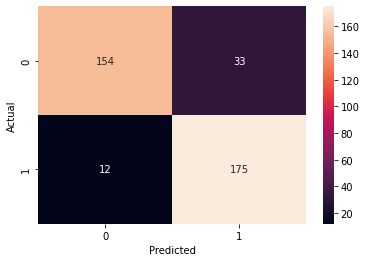

In [20]:
# Creating Confusion Matrix 
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [21]:
# Classification Report
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       187
           1       0.84      0.94      0.89       187

    accuracy                           0.88       374
   macro avg       0.88      0.88      0.88       374
weighted avg       0.88      0.88      0.88       374



### Model Prediction on set of samples

1. Create a list that contains a collection of few spam and ham emails
2. Predict the sentence category using our model and store the result in variable ‘test_result‘.
3. Create a lambda function for filtering values greater than ‘as spam’ else, not ‘spam’ using NumPy. 


In [22]:
predict_text = [
                # Spam
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest', 
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund', 
                'Your account is temporarily frozen. Please log in to to secure your account ', 
                # Ham
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
]

In [23]:
test_results = model.predict(predict_text)
output = np.where(test_results > 0.5,'spam', 'ham')
output

1/1 [==============================] - 1s 753ms/step


array([['spam'],
       ['spam'],
       ['spam'],
       ['ham'],
       ['spam'],
       ['spam']], dtype='<U4')

### Please answer the questions below to complete the experiment:

In [24]:
#@title State True or False: BERT provides a bidirectional context and the model uses previous and the next sentence to arrive at the context during a training phase.{ run: "auto", form-width: "500px", display-mode: "form" }
Answer = "True" #@param ["","True","False"]


In [25]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [26]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "Everything is good" #@param {type:"string"}


In [27]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [28]:
#@title  Experiment walkthrough video? { run: "auto", vertical-output: true, display-mode: "form" }
Walkthrough = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [29]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [30]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [31]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 3887
Date of submission:  25 Oct 2022
Time of submission:  15:04:33
View your submissions: https://aiml.iiith.talentsprint.com/notebook_submissions
